In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Importing necessary libraries
import numpy as np  # For linear algebra
import pandas as pd  # For data manipulation and CSV I/O
import os  # For file operations
import csv
import math
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
import graphviz


# Listing all files in the input directory
input_directory = '/kaggle/input/cryotherapy'  # Specify the input directory
for dirname, _, filenames in os.walk(input_directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cryotherapy/Cryotherapy.csv


In [4]:
# File path to the dataset
file_path = '/kaggle/input/cryotherapy/Cryotherapy.csv'  # Adjust if needed

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate features (X) and target (y)
X = df.iloc[:, :-1]  # All columns except the last one as features
y = df.iloc[:, -1]   # The last column as the target variable

# Display the first few rows of the dataset
print("Dataset Preview:")
print(df.head())


Dataset Preview:
   sex  age   Time  Number_of_Warts  Type  Area  Result_of_Treatment
0    1   35  12.00                5     1   100                    0
1    1   29   7.00                5     1    96                    1
2    1   50   8.00                1     3   132                    0
3    1   32  11.75                7     3   750                    0
4    1   67   9.25                1     1    42                    0


In [5]:
df.info()
df.describe()
df.isnull().sum()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  90 non-null     int64  
 1   age                  90 non-null     int64  
 2   Time                 90 non-null     float64
 3   Number_of_Warts      90 non-null     int64  
 4   Type                 90 non-null     int64  
 5   Area                 90 non-null     int64  
 6   Result_of_Treatment  90 non-null     int64  
dtypes: float64(1), int64(6)
memory usage: 5.0 KB


,sex,age,Time,Number_of_Warts,Type,Area,Result_of_Treatment
0,1,35,12.00,5,1,100,0
1,1,29,7.00,5,1,96,1
2,1,50,8.00,1,3,132,0
3,1,32,11.75,7,3,750,0
4,1,67,9.25,1,1,42,0


In [8]:
# Define a function to preprocess the dataset (convert to numerical values where applicable)
def preprocess_data(rows):
    for row in rows:
        for i in range(len(row)):
            try:
                row[i] = float(row[i])  # Convert to float if possible
            except ValueError:
                pass  # Leave non-numeric values unchanged
    return rows

# Load data into a list of rows (from the DataFrame)
data = df.values.tolist()  # Convert the DataFrame to a list of lists

# Preprocess the data
data = preprocess_data(data)

# Display the first few preprocessed rows
print("Preprocessed Data (First 5 Rows):")
print(data[:5])


Preprocessed Data (First 5 Rows):
[[1.0, 35.0, 12.0, 5.0, 1.0, 100.0, 0.0], [1.0, 29.0, 7.0, 5.0, 1.0, 96.0, 1.0], [1.0, 50.0, 8.0, 1.0, 3.0, 132.0, 0.0], [1.0, 32.0, 11.75, 7.0, 3.0, 750.0, 0.0], [1.0, 67.0, 9.25, 1.0, 1.0, 42.0, 0.0]]


In [12]:
# Calculate Gini Impurity
def gini_index(groups, classes):
    n_instances = sum([len(group) for group in groups])  # Total samples
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:  # Avoid division by zero
            continue
        score = 0.0
        for class_val in classes:
            proportion = [row[-1] for row in group].count(class_val) / size
            score += proportion ** 2
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Split data based on feature and threshold
def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Find the best split
def get_best_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = None, None, float('inf'), None
    for index in range(len(dataset[0]) - 1):  # Exclude the label column
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}


In [13]:
# Create a terminal node
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return Counter(outcomes).most_common(1)[0][0]

# Build tree recursively
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    
    # Check for a no-split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    
    # Check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    
    # Process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_best_split(left)
        split(node['left'], max_depth, min_size, depth + 1)
    
    # Process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_best_split(right)
        split(node['right'], max_depth, min_size, depth + 1)

# Build decision tree
def build_tree(train, max_depth, min_size):
    root = get_best_split(train)
    split(root, max_depth, min_size, 1)
    return root


In [14]:
# Make a prediction with the tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']


In [15]:
# Split into train and test datasets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Train decision tree
max_depth = 5
min_size = 10
tree = build_tree(train_data, max_depth, min_size)
print("Decision tree built successfully.")


Decision tree built successfully.


In [16]:
# Evaluate predictions with metrics
def calculate_metrics(predictions, actual):
    tp = sum(1 for p, a in zip(predictions, actual) if p == a and a == 1)
    tn = sum(1 for p, a in zip(predictions, actual) if p == a and a == 0)
    fp = sum(1 for p, a in zip(predictions, actual) if p != a and a == 0)
    fn = sum(1 for p, a in zip(predictions, actual) if p != a and a == 1)

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Confusion Matrix
    confusion_matrix = {
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    }

    return accuracy, precision, recall, f1_score, confusion_matrix

# Make predictions
predictions = [predict(tree, row) for row in test_data]
actual = [row[-1] for row in test_data]

# Calculate evaluation metrics
accuracy, precision, recall, f1_score, confusion_matrix = calculate_metrics(predictions, actual)

# Print metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Confusion Matrix: {confusion_matrix}")


Evaluation Metrics:
Accuracy: 0.83
Precision: 0.85
Recall: 0.92
F1 Score: 0.88
Confusion Matrix: {'TP': 11, 'TN': 4, 'FP': 2, 'FN': 1}


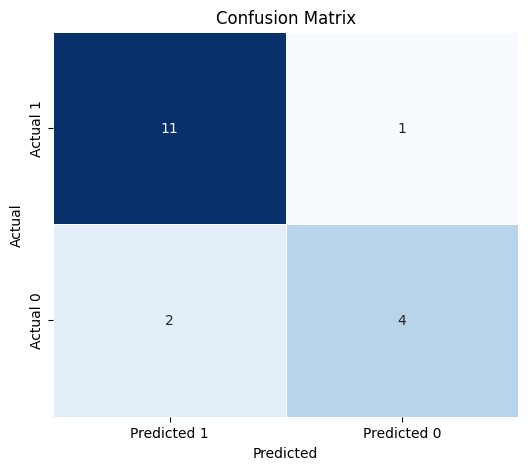

In [18]:
# Function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, class_labels):
    """
    Plots a confusion matrix using Seaborn heatmap.
    
    Args:
    confusion_matrix (dict): Confusion matrix containing TP, TN, FP, FN.
    class_labels (list): List of class labels.
    """
    # Create a matrix for plotting
    matrix = [
        [confusion_matrix['TP'], confusion_matrix['FN']],  # Row for positive class
        [confusion_matrix['FP'], confusion_matrix['TN']]   # Row for negative class
    ]
    
    # Convert to DataFrame for labeling
    matrix_df = pd.DataFrame(matrix, index=[f"Actual {label}" for label in class_labels],
                             columns=[f"Predicted {label}" for label in class_labels])
    
    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Example usage
class_labels = [1, 0]  # Adjust based on your dataset
plot_confusion_matrix(confusion_matrix, class_labels)